# Проект восстановление золота из руды

## Описание проекта

Была построена модель, предсказывающая коэффициент восстановления золота из руды.

- `gold_recovery_train_new.csv` — обучающая выборка;
- `gold_recovery_test_new.csv` — тестовая выборка;
- `gold_recovery_full_new.csv` — исходные данные.

---

## Импорты

### Импорт библиотек

In [70]:
from io import BytesIO
import requests
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport
import sweetviz as sv
from scipy import stats as st

from sklearn.metrics import (mean_absolute_error, mean_squared_error,
                             make_scorer)
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import BayesianRidge, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.dummy import DummyRegressor

from catboost import CatBoostRegressor


### Константы

In [71]:
RANDOM_STATE = 777

### Импорт данных

In [72]:
def get_data_csv(sheet_id:str) -> pd.DataFrame:
    url = f"https://docs.google.com/spreadsheets/d/{sheet_id}" \
          f"/export?format=csv"
    
    r = requests.get(url)
    data = pd.read_csv(BytesIO(r.content))
    return data

In [73]:
try:
    data_gold_recovery_full = pd.read_csv('../datasets/gold_recovery_full_new.csv')
    data_gold_recovery_test = pd.read_csv('../datasets/gold_recovery_test_new.csv')
    data_gold_recovery_train = pd.read_csv('../datasets/gold_recovery_train_new.csv')
except:
    spreadsheet_id_full = '1QY_EXDUzPv69AkZ1PASnlSkNZFHmX4IGCOcaeCZ74Ac'
    spreadsheet_id_test = '12XWiIyU9HKY5uCBoQoz5UA4CZOvoaH_MHQR_88qeUXU'
    spreadsheet_id_train = '1qa9DcU5gu7LhQz7uEc9RDuaSdNcTK6k7-h8B2WVW74A'
    data_gold_recovery_full = get_data_csv(spreadsheet_id_full)
    data_gold_recovery_test = get_data_csv(spreadsheet_id_test)
    data_gold_recovery_train = get_data_csv(spreadsheet_id_train)

---

## EDA

### Краткий обзор данных

In [74]:
# analyze_report = sv.analyze(data_gold_recovery_full)
# analyze_report.show_html('report.html', open_browser=True)

In [75]:
# profile = ProfileReport(data_gold_recovery_full, title="Report", minimal = True)
# profile

Для начала проверим, сколько колонок имеет каждый из датасетов

In [76]:
print(f'Датасет full имеет {len(data_gold_recovery_full.columns)} колонки')
print(f'Датасет train имеет {len(data_gold_recovery_train.columns)} колонки')
print(f'Датасет test имеет {len(data_gold_recovery_test.columns)} колонки')

Датасет full имеет 87 колонки
Датасет train имеет 87 колонки
Датасет test имеет 53 колонки


In [77]:
print(data_gold_recovery_full.shape)
print(data_gold_recovery_train.shape)
print(data_gold_recovery_test.shape)

(19439, 87)
(14149, 87)
(5290, 53)


Итого в целом убеждаемся, что full = train + test

In [78]:
print('train')
display(data_gold_recovery_train.info())
print('-'*80)
display(data_gold_recovery_test.info())


train
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                               14144 non-null  fl

None

--------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   prim

None

Мы видим все данные числовые. Также имеются пропуски, но нету именно больших пробелов в данных. То есть в целом данные собираются корректно \
При этом в выборке train имеются данные с одним - двумя пропусками

- Сразу приходит задумка сгруппировать столбцы по процессам очистки
- Еще в этих данных скорее всего поможет L1 регуляризация, которая отбрасывает ненужные признаки

### Проверка на дубликаты

In [79]:
data_gold_recovery_train.duplicated().sum()

0

Дубликатов нет

### Проверка на пропущенные значения 

In [80]:
data_gold_recovery_train.isna().sum().sum()

4100

Пропущенные значения есть

### Изменение формата даты

In [81]:
data_gold_recovery_train['date'] = pd.to_datetime(data_gold_recovery_train['date'])
# data_gold_recovery_test['date'] = pd.to_datetime(data_gold_recovery_test['date'])

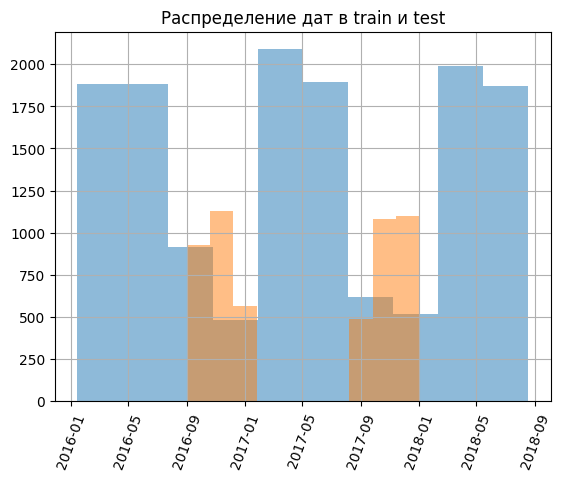

In [82]:
data_gold_recovery_train.date.hist(alpha = 0.5,bins = 10)
data_gold_recovery_test.date.hist(alpha = 0.5,bins = 10)

plt.xticks(rotation=70)
plt.title('Распределение дат в train и test')
plt.show()


Мы видим, что данные "выбрали из середины", а не случайным образом

### Измение формата колонок

In [83]:
data_gold_recovery_train.columns = [x.replace('.','_') for x in 
                                data_gold_recovery_train.columns]

data_gold_recovery_test.columns = [x.replace('.','_') for x in 
                                data_gold_recovery_test.columns]

data_gold_recovery_full.columns = [x.replace('.','_') for x in 
                                data_gold_recovery_full.columns]

### Интерпретация данных

In [84]:
# создадим класс для быстрого отчёта по данным
# класс нужен, чтобы избежать дублирования кода
# и в случае новых данных быстро добавить их в отчёт
class GET_EDA():
    def __init__(self,data_, list_columns,corr_coef = 0.7):
        self.list_columns = list_columns
        self.data_ = data_
        self.corr_coef = corr_coef
        
    def _get_head(self):
        return self.data_[self.list_columns].head()
    
    def _check_null(self):
        """проверка на нули"""
        return self.data_[self.list_columns].isna().sum()
    
    def _get_describe(self):
        """проверка распределения"""
        return self.data_[self.list_columns].describe(
               percentiles = [0.5]).loc[['mean','std','min','50%','max']]
    def _get_plot(self):
        """построение hist"""
        self.data_[self.list_columns].hist(figsize = (6,6))
        plt.show()
        
    def _get_table_middle_corr(self,column):
        """функция возвращает таблицу по заданному столбцу, где у него
        в датасете есть сильная корреляция"""
        return self.data_.corr()[[column]].query(
            f'{column} < -{self.corr_coef} or {column} > {self.corr_coef}')
        
    def _get_corr_columns(self):
        """функция собирает столбцы между которыми есть корреляция
        и возвращает"""
        columns_corr = set()
        for col in self.list_columns:
            columns_corr = columns_corr.union(
                set(self._get_table_middle_corr(col).index))
        return sorted(columns_corr)
    
    def _get_hearmap_corr(self):
        """Фунция строит heatmap по столбцам, между которыми есть корреляция"""
        data_corr_ = self.data_[self._get_corr_columns()].corr()
        matrix = np.triu(data_corr_)
        sns.heatmap(data_corr_, annot=True, mask=matrix, cbar=False,
                   fmt='.1g',vmin=-1, vmax=1, cmap= 'coolwarm')
        plt.show()
        
    def get_report(self):
        print("Данные")
        display(self._get_head())
        print("Нулевые значения")
        display(self._check_null())
        print()
        print('Распределение')
        display(self._get_describe())
        print()
        self._get_plot()
        print('Матрица корреляций')
        self._get_hearmap_corr()
        
    


#### Флотация
 - rougher.input - параметры сырья(входящий продукт)
     - feed - исходное сырьё. 
         - ag, au, pb - металлы. Вес или концентрация
         - rate - скорость подачи 
         - size - размер гранул сырья
         - sol - похоже на соль, будем считать это солью или примесями
     - floatbank - флотационная установка
         - 10 и 11, флотационная установка, скорее всего этапы
         - sulfate, xanthate - флотационные реагенты
 - rougher.output - параметры продукта(выходные данные)
      - tail - отвальные хвосты (ag, au, pb,sol)
      - concentrate - доля в концентрате
      - rougher.output.recovery - эффективность обогащения чернового концентрата
 - rougher_state - параметры, характеризующие текущее состояние этапа
      - air - объём воздуха
      - level - уровень жидкости
 - rougher_calculation - рассчетные характеристики

##### ag, au, pb, sol

Данные


,rougher_input_feed_ag,rougher_input_feed_pb,rougher_input_feed_au,rougher_input_feed_sol
0,6.100378,2.284912,6.486150,36.808594
1,6.161113,2.266033,6.478583,35.753385
2,6.116455,2.159622,6.362222,35.971630
3,6.043309,2.037807,6.118189,36.862241
4,6.060915,1.786875,5.663707,34.347666


Нулевые значения


rougher_input_feed_ag       0
rougher_input_feed_pb     100
rougher_input_feed_au       0
rougher_input_feed_sol     78
dtype: int64


Распределение


,rougher_input_feed_ag,rougher_input_feed_pb,rougher_input_feed_au,rougher_input_feed_sol
mean,8.579195,3.522778,7.866577,36.312593
std,1.896284,1.073394,1.919506,4.956057
min,0.010000,0.010000,0.010000,0.010000
50%,8.156092,3.422677,7.649138,37.020345
max,14.596026,7.142594,13.126043,48.363177


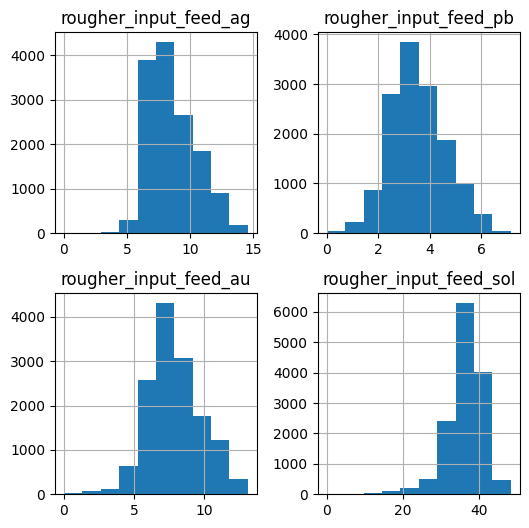

Матрица корреляций


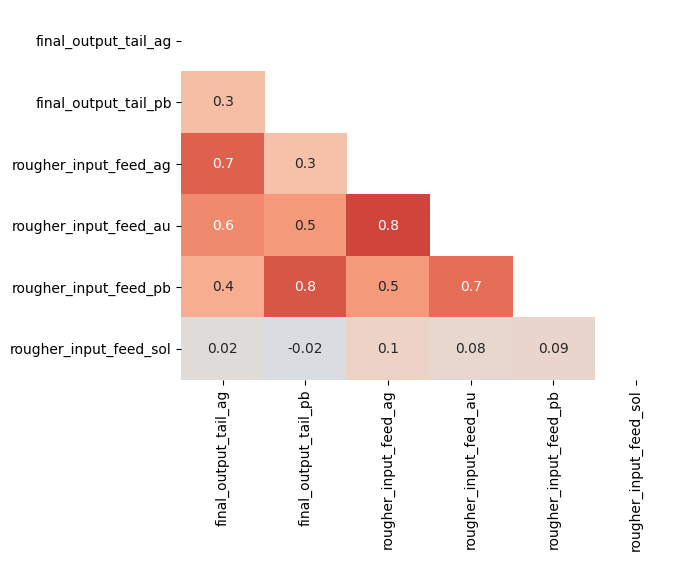

In [85]:
GET_EDA(data_gold_recovery_train, 
        ['rougher_input_feed_ag',
         'rougher_input_feed_pb',
         'rougher_input_feed_au',
         'rougher_input_feed_sol']).get_report()

- Видно, что во входящих данных есть пропущенные значения. То есть это пропущенное значение будем заменять на 0
- Также стоит заметить что финальные характеристики pb и ag сильно коррелируют между собой, в отличие от золота

#### Первичная и вторичная очистка

- primary_cleaner_input - входные данные на первичной очистке
    - sulfate - сульфат 
    - depressant - депрессант
    - xanthate - ксантогенат 
    - feed_size - размер гранул сырья
- primary_cleaner_output - выходные данные
    - tail - хвосты
    - concentrate - концентрат
- primary_cleaner_state - параметры, характеризующие текущее состояние этапа
    - air - объём воздуха
    - level - уровень жидкости
- secondary_cleaner_output - выходные данные
    - tail - хвосты
- secondary_cleaner_state - параметры, характеризующие текущее состояние этапа

Данные


,secondary_cleaner_output_tail_ag,secondary_cleaner_output_tail_pb,secondary_cleaner_output_tail_sol,secondary_cleaner_output_tail_au
0,14.500184,4.694824,8.764648,2.606185
1,14.265474,4.592547,9.001494,2.488248
2,14.115662,4.624775,8.842896,2.458187
3,13.732071,4.482453,9.122857,2.322062
4,14.079996,4.470737,8.871028,2.330448


Нулевые значения


secondary_cleaner_output_tail_ag        2
secondary_cleaner_output_tail_pb       10
secondary_cleaner_output_tail_sol    1605
secondary_cleaner_output_tail_au        0
dtype: int64


Распределение


,secondary_cleaner_output_tail_ag,secondary_cleaner_output_tail_pb,secondary_cleaner_output_tail_sol,secondary_cleaner_output_tail_au
mean,14.281629,5.848863,6.938693,4.246961
std,4.477126,2.861799,4.155487,2.389060
min,0.000000,0.000000,0.000000,0.000000
50%,15.357951,5.442310,7.302639,3.980210
max,23.264738,17.042505,17.976171,26.811643


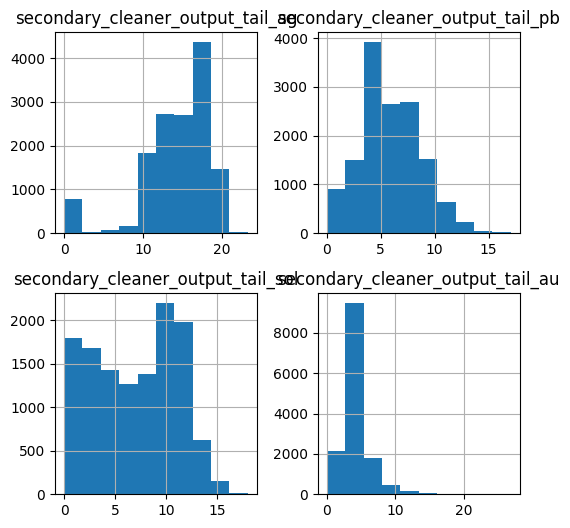

Матрица корреляций


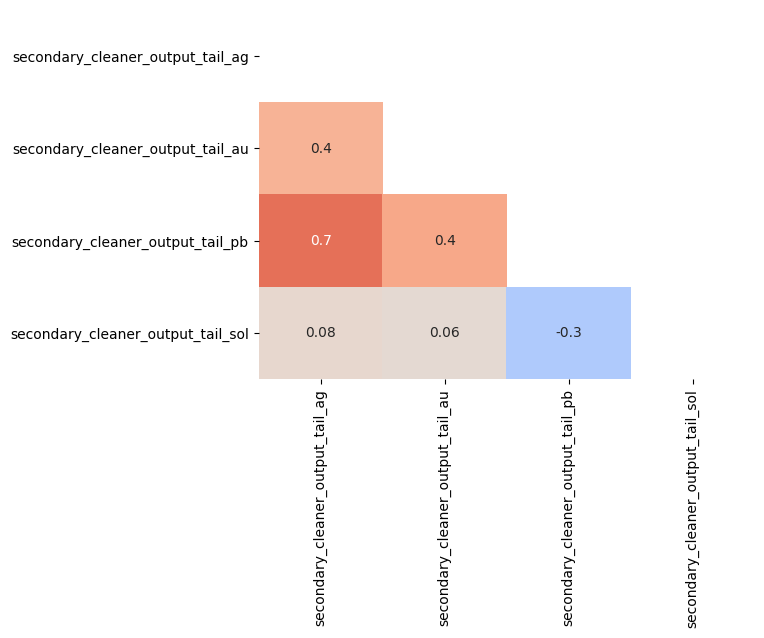

In [86]:
GET_EDA(data_gold_recovery_train, 
        ['secondary_cleaner_output_tail_ag',
         'secondary_cleaner_output_tail_pb',
         'secondary_cleaner_output_tail_sol',
         'secondary_cleaner_output_tail_au']).get_report()

- корреляция между ag и pd
- значительные пропуски в выходных данных солей

Данные


,secondary_cleaner_state_floatbank2_a_air,secondary_cleaner_state_floatbank2_a_level,secondary_cleaner_state_floatbank3_a_air,secondary_cleaner_state_floatbank3_a_level,secondary_cleaner_state_floatbank4_a_air,secondary_cleaner_state_floatbank4_a_level,secondary_cleaner_state_floatbank5_a_air,secondary_cleaner_state_floatbank5_a_level,secondary_cleaner_state_floatbank6_a_air,secondary_cleaner_state_floatbank6_a_level
0,25.853109,-498.526489,23.961798,-495.262817,14.016835,-502.488007,9.925633,-498.310211,14.151341,-605.841980
1,25.880539,-499.989656,23.970550,-500.085473,13.992281,-505.503262,10.039245,-500.169983,13.998353,-599.787184
2,26.005245,-499.929616,23.913535,-499.442343,14.015015,-502.520901,10.070913,-500.129135,14.028663,-601.427363
3,25.942508,-499.176749,23.966838,-500.008812,14.036510,-500.857308,9.970366,-499.201640,14.005551,-599.996129
4,26.024787,-500.279091,23.985703,-500.083811,14.027298,-499.838632,9.925709,-501.686727,13.996647,-601.496691


Нулевые значения


secondary_cleaner_state_floatbank2_a_air      217
secondary_cleaner_state_floatbank2_a_level      1
secondary_cleaner_state_floatbank3_a_air        4
secondary_cleaner_state_floatbank3_a_level      1
secondary_cleaner_state_floatbank4_a_air        6
secondary_cleaner_state_floatbank4_a_level      1
secondary_cleaner_state_floatbank5_a_air        1
secondary_cleaner_state_floatbank5_a_level      1
secondary_cleaner_state_floatbank6_a_air        2
secondary_cleaner_state_floatbank6_a_level      1
dtype: int64


Распределение


,secondary_cleaner_state_floatbank2_a_air,secondary_cleaner_state_floatbank2_a_level,secondary_cleaner_state_floatbank3_a_air,secondary_cleaner_state_floatbank3_a_level,secondary_cleaner_state_floatbank4_a_air,secondary_cleaner_state_floatbank4_a_level,secondary_cleaner_state_floatbank5_a_air,secondary_cleaner_state_floatbank5_a_level,secondary_cleaner_state_floatbank6_a_air,secondary_cleaner_state_floatbank6_a_level
mean,29.613649,-502.223914,29.243372,-478.244059,19.985454,-478.696836,16.775136,-483.956022,19.577539,-506.798480
std,5.800494,60.281705,5.637309,54.655143,5.657723,50.736021,5.831906,37.892788,5.764417,37.079249
min,0.077503,-799.606441,0.000000,-799.613013,0.000000,-799.709069,-0.372054,-797.142475,0.195324,-809.398668
50%,30.027721,-499.959206,28.016530,-499.877837,20.001789,-499.681450,17.932223,-499.702452,19.984175,-500.061431
max,52.651399,-127.875565,44.260464,-191.678810,30.115735,-245.239184,43.709931,-275.073125,32.188906,-104.427459


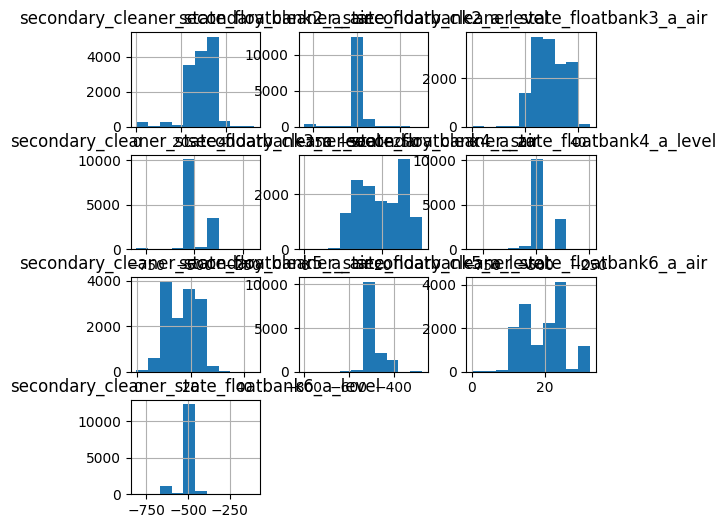

Матрица корреляций


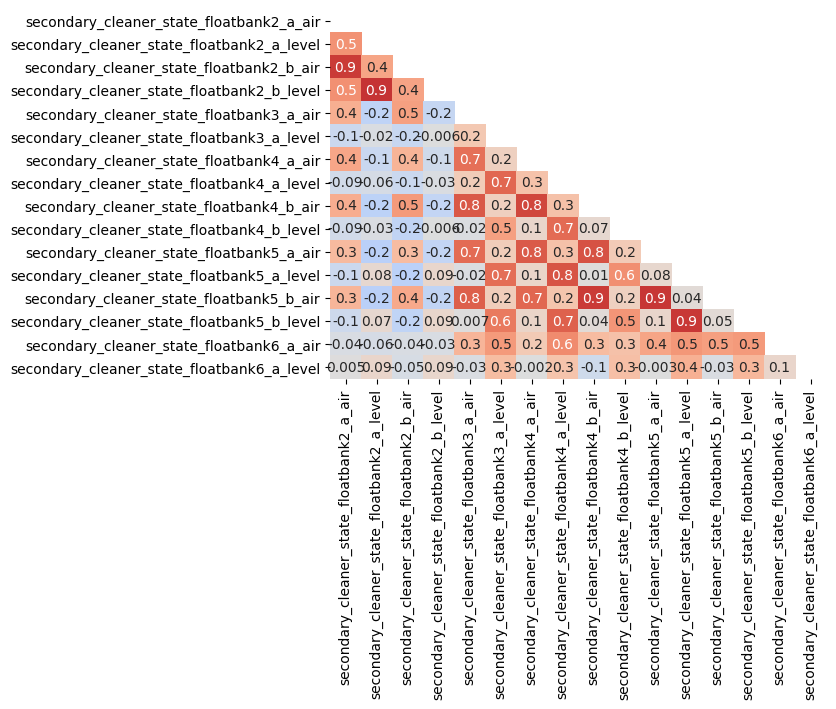

In [87]:
GET_EDA(data_gold_recovery_train, 
        ['secondary_cleaner_state_floatbank2_a_air',
         'secondary_cleaner_state_floatbank2_a_level',
         'secondary_cleaner_state_floatbank3_a_air',
         'secondary_cleaner_state_floatbank3_a_level',
         'secondary_cleaner_state_floatbank4_a_air',
         'secondary_cleaner_state_floatbank4_a_level',
         'secondary_cleaner_state_floatbank5_a_air',
         'secondary_cleaner_state_floatbank5_a_level',
         'secondary_cleaner_state_floatbank6_a_air',
         'secondary_cleaner_state_floatbank6_a_level']).get_report()

- часть признаков можно удалить, так как они имеют между собой сильную корреляцию
- secondary_cleaner_state_floatbank2_a_air не имеет сильное корреляцию и большое количество пропусков придется заменять другими значениями

#### Финальный этап
- final_output_concentrate - концентрат
- final_output_tail - хвосты
- final_output_recovery - эффективность

Данные


,final_output_concentrate_ag,final_output_concentrate_pb,final_output_concentrate_sol,final_output_concentrate_au
0,6.055403,9.889648,5.507324,42.192020
1,6.029369,9.968944,5.257781,42.701629
2,6.055926,10.213995,5.383759,42.657501
3,6.047977,9.977019,4.858634,42.689819
4,6.148599,10.142511,4.939416,42.774141


Нулевые значения


final_output_concentrate_ag       1
final_output_concentrate_pb       1
final_output_concentrate_sol    211
final_output_concentrate_au       0
dtype: int64


Распределение


,final_output_concentrate_ag,final_output_concentrate_pb,final_output_concentrate_sol,final_output_concentrate_au
mean,5.142034,10.132960,9.202849,44.003792
std,1.369586,1.654930,2.790516,4.905261
min,0.000000,0.000000,0.000000,0.000000
50%,4.994652,10.297144,8.845462,44.872436
max,16.001945,17.031899,18.124851,52.756638


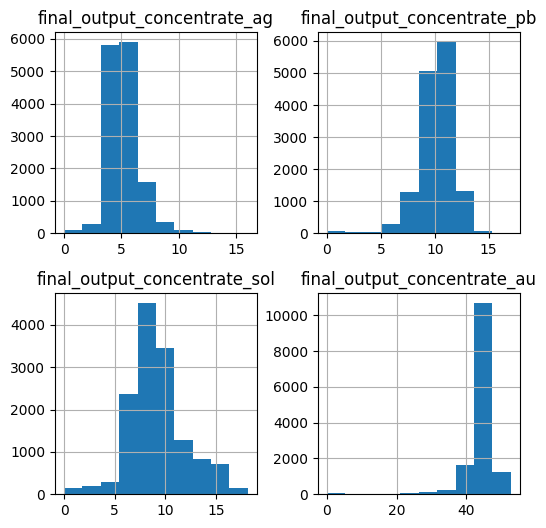

Матрица корреляций


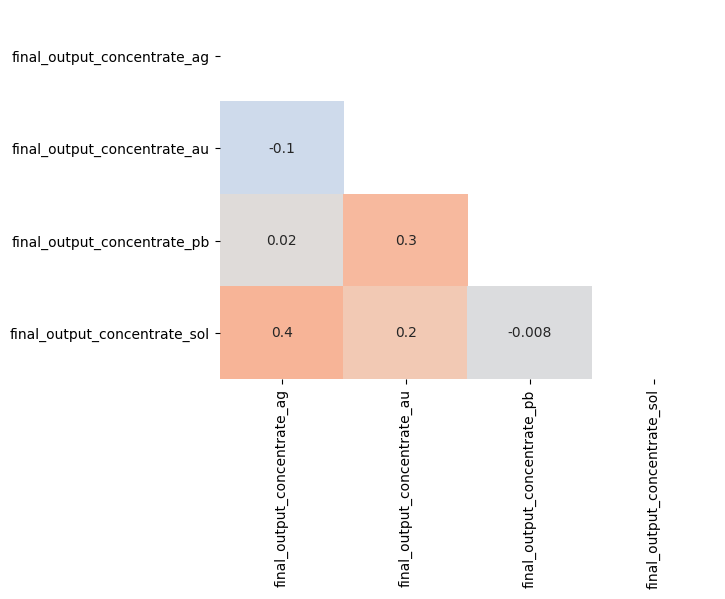

In [88]:
GET_EDA(data_gold_recovery_train, 
        ['final_output_concentrate_ag',
         'final_output_concentrate_pb',
         'final_output_concentrate_sol',
         'final_output_concentrate_au']).get_report()

- Корреляции не наблюдается
- Имеются пропуски в sol, и незначительные пропуски в других показателях

Данные


,final_output_tail_ag,final_output_tail_pb,final_output_tail_sol,final_output_tail_au
0,10.411962,0.895447,16.904297,2.143149
1,10.462676,0.927452,16.634514,2.224930
2,10.507046,0.953716,16.208849,2.257889
3,10.422762,0.883763,16.532835,2.146849
4,10.360302,0.792826,16.525686,2.055292


Нулевые значения


final_output_tail_ag       0
final_output_tail_pb     100
final_output_tail_sol      5
final_output_tail_au       0
dtype: int64


Распределение


,final_output_tail_ag,final_output_tail_pb,final_output_tail_sol,final_output_tail_au
mean,9.607035,2.597298,10.512122,2.918421
std,2.319069,0.971843,3.003617,0.903712
min,0.000000,0.000000,0.000000,0.000000
50%,9.480270,2.592022,10.514621,2.851025
max,19.552149,5.639565,22.317730,8.197408


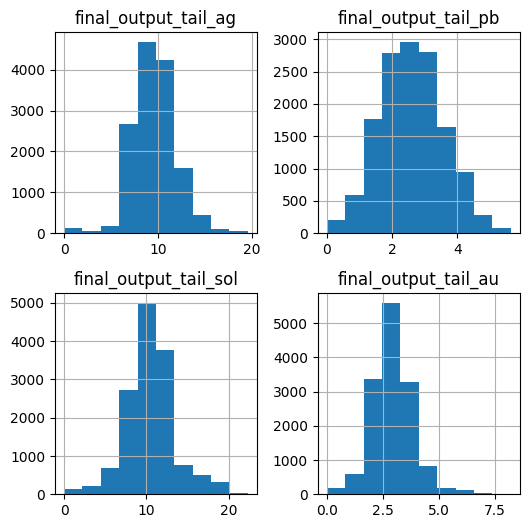

Матрица корреляций


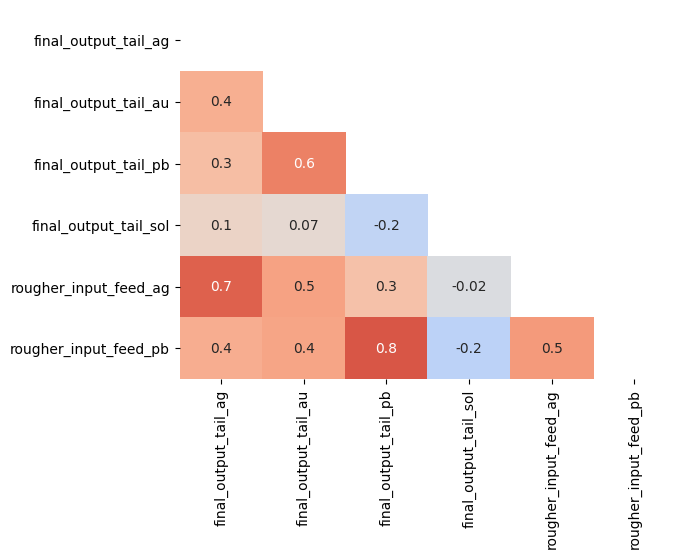

In [89]:
GET_EDA(data_gold_recovery_train, 
        ['final_output_tail_ag',
         'final_output_tail_pb',
         'final_output_tail_sol',
         'final_output_tail_au']).get_report()

- пропуски pd можно заменить на 0 либо удалить, так как имеется другой столбце с сильной корреляцией без пропусков

Данные


,final_output_recovery
0,70.541216
1,69.266198
2,68.116445
3,68.347543
4,66.927016


Нулевые значения


final_output_recovery    0
dtype: int64


Распределение


,final_output_recovery
mean,66.518832
std,10.295402
min,0.000000
50%,67.432775
max,100.000000


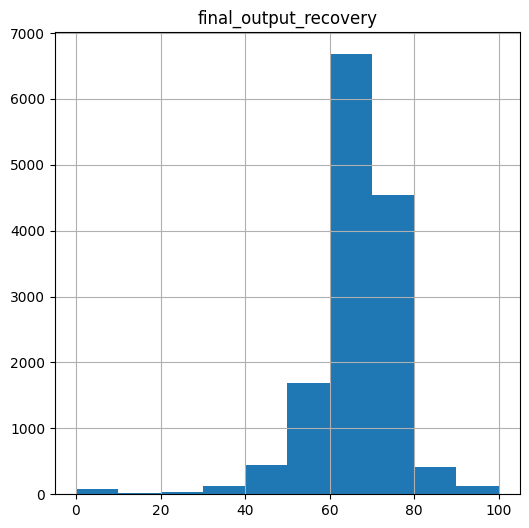

Матрица корреляций


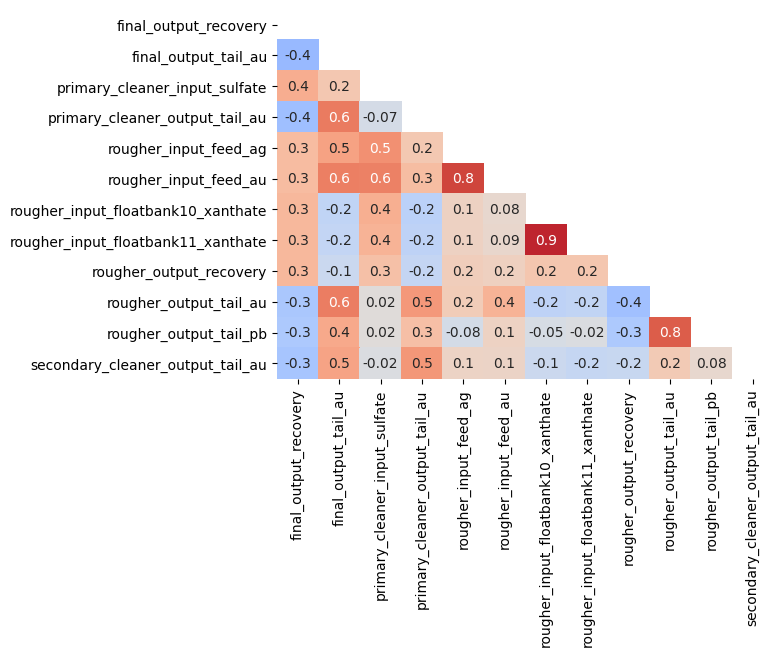

In [90]:
GET_EDA(data_gold_recovery_train, 
        ['final_output_recovery'],corr_coef = 0.3).get_report()

- Финальная эффективность не имеет пропусков
- Финальная эффективность не имеет корреляций

---

## Проверка эффективности обогащения

Эффективность обогащения рассчитывается по формуле

\begin{align*}
Recovery = \frac {C * (F-T)}{F * (C-T)}
\end{align*} 

где:
- **C**  — доля золота в концентрате после флотации/очистки;
- **F**  — доля золота в сырье/концентрате до флотации/очистки;
- **T**  — доля золота в отвальных хвостах после флотации/очистки.

### Эффективность обогащения на финальном этапе

`final_output_recovery` - эффективность обогащения \
`rougher_input_feed_au` - доля золота до флотации \
`final_output_tail_au` - доля золота в хвостах \
`final_output_concentrate_au` - доля сырья после очистки

In [91]:
C = data_gold_recovery_train['final_output_concentrate_au']
F = data_gold_recovery_train['rougher_input_feed_au']
T = data_gold_recovery_train['final_output_tail_au']

In [92]:
data_gold_recovery_train['recovery_temp'] = (C * (F - T)) / (F * (C - T)) * 100

In [93]:
data_gold_recovery_train[['recovery_temp','final_output_recovery']].isna().sum()

recovery_temp            0
final_output_recovery    0
dtype: int64

In [94]:
mean_absolute_error(data_gold_recovery_train['recovery_temp'], 
                    data_gold_recovery_train['final_output_recovery'])

8.538049763979541e-15

Итак ошибка почти нулевая и связана с особенностью хранения данных в python, следовательно recovery подсчитано верно

### Эффективность обогащения на этапе флотации

`rougher_output_recovery` - эффективность обогащения на этапе флотации \
`rougher_input_feed_au` - доля золота до флотации \
`rougher_output_tail_au` - доля золота в хвостах \
`rougher_output_concentrate_au` - доля сырья после флотации

In [95]:
C = data_gold_recovery_train['rougher_output_concentrate_au']
F = data_gold_recovery_train['rougher_input_feed_au']
T = data_gold_recovery_train['rougher_output_tail_au']

In [96]:
data_gold_recovery_train['recovery_temp'] = (C * (F - T)) / (F * (C - T)) * 100

In [97]:
mean_absolute_error(data_gold_recovery_train['recovery_temp'], 
                    data_gold_recovery_train['rougher_output_recovery'])

9.73512347450521e-15

In [98]:
data_gold_recovery_train.drop(columns = 'recovery_temp',inplace = True)

Эффективность на тестовой выборке посчитана верно

### Проверка столбцов train/test

In [99]:
set(data_gold_recovery_train.columns) - set(data_gold_recovery_test.columns)

{'final_output_concentrate_ag',
 'final_output_concentrate_au',
 'final_output_concentrate_pb',
 'final_output_concentrate_sol',
 'final_output_recovery',
 'final_output_tail_ag',
 'final_output_tail_au',
 'final_output_tail_pb',
 'final_output_tail_sol',
 'primary_cleaner_output_concentrate_ag',
 'primary_cleaner_output_concentrate_au',
 'primary_cleaner_output_concentrate_pb',
 'primary_cleaner_output_concentrate_sol',
 'primary_cleaner_output_tail_ag',
 'primary_cleaner_output_tail_au',
 'primary_cleaner_output_tail_pb',
 'primary_cleaner_output_tail_sol',
 'rougher_calculation_au_pb_ratio',
 'rougher_calculation_floatbank10_sulfate_to_au_feed',
 'rougher_calculation_floatbank11_sulfate_to_au_feed',
 'rougher_calculation_sulfate_to_au_concentrate',
 'rougher_output_concentrate_ag',
 'rougher_output_concentrate_au',
 'rougher_output_concentrate_pb',
 'rougher_output_concentrate_sol',
 'rougher_output_recovery',
 'rougher_output_tail_ag',
 'rougher_output_tail_au',
 'rougher_output_ta

В выборке представлены параметры

- продукты на всех этапах очистки
- рассчетные данные (в том числе recovery)

То есть задача сводится к тому, чтобы имея на руках данные до начала очистки предсказать recovery

Текущие данные, это данные, которые не получится предсказать до того, пока мы не начнем процесс очистки

### Preprocessing

Для корректной работы модели колонки train и test должны совпадать \
И если мы на тестовой выборке не можем получить данные, их необходимо удалить

#### Определение пропусков

In [100]:
# train данные это train датасет с колонками из test
# так как в тесте нету recovery все корректно
features_train = data_gold_recovery_train[data_gold_recovery_test.columns]
target_train = data_gold_recovery_train[['rougher_output_recovery'
                                         ,'final_output_recovery']]

features_test = data_gold_recovery_test.copy()

В тестовом датасете нету целевых значений, попробуем подтянуть их из full датасета

Попробуем подтянуть по дате и проверим данные на дубликаты

In [101]:
data_gold_recovery_full.date.duplicated().sum()

0

In [102]:
data_gold_recovery_test.date.duplicated().sum()

0

Дубликатов нету

In [103]:
target_test = data_gold_recovery_test.merge(
    data_gold_recovery_full, on = 'date')[['rougher_output_recovery'
                                           ,'final_output_recovery']]

In [104]:
features_train.drop(columns = ['date'],inplace = True)
features_test.drop(columns = ['date'],inplace = True)

#### Обработка пропусков

In [105]:
data_null = pd.concat([features_train.isna().sum()
            ,features_train.isna().sum() / features_train.shape[0] * 100],
                      axis = 1)
data_null.columns = ['count_null', 'per_null']
data_null['per_null'] = data_null['per_null'].round(2)
data_null = data_null.query('count_null > 0')
data_null.sort_values('count_null', ascending = False)

,count_null,per_null
rougher_state_floatbank10_e_air,436,3.08
rougher_input_floatbank11_xanthate,428,3.02
secondary_cleaner_state_floatbank2_a_air,217,1.53
rougher_input_feed_size,144,1.02
rougher_input_feed_pb,100,0.71
primary_cleaner_input_xanthate,100,0.71
rougher_input_feed_sol,78,0.55
rougher_input_floatbank11_sulfate,36,0.25
primary_cleaner_input_depressant,32,0.23
rougher_input_floatbank10_sulfate,29,0.20


Так как ранее в данных мы видели сильную корреляции между разными данными выберем более сложную стратегию заполнения пропусков

In [106]:
features_train_for_miss_target = features_train.dropna().sample(frac = 0.2,
                                                    random_state = RANDOM_STATE)
features_train_for_miss_target = StandardScaler().fit_transform(
                                    features_train_for_miss_target)

features_train_for_miss_target= pd.DataFrame(
    data = features_train_for_miss_target, columns = features_train.columns)
features_train_for_miss = features_train_for_miss_target.copy()

In [107]:
n_samples, n_features = features_train_for_miss.shape
rng = np.random.RandomState(RANDOM_STATE)

In [108]:
for i in range(n_features):
    features_train_for_miss.iloc[rng.choice(n_samples, 
            round(n_samples/100), replace=False),i] = np.nan

Проверка стратегий и выбор лучшей

In [109]:
estimators = [
    BayesianRidge(),
    RandomForestRegressor(
        n_estimators=4,
        max_depth=3,
        max_samples=0.5,
        n_jobs=2,
        random_state=RANDOM_STATE,
    ),
    KNeighborsRegressor(n_neighbors=15),
]


for impute_estimator in estimators:
    values_ = IterativeImputer(
            random_state=RANDOM_STATE, estimator=impute_estimator, max_iter=10
        ).fit_transform(features_train_for_miss)
    print(mean_squared_error(values_, features_train_for_miss_target))
    
values_ = SimpleImputer().fit_transform(features_train_for_miss)
print(mean_squared_error(values_, features_train_for_miss_target))
    


0.0018270249759749374
0.0019824704396613577
0.0015288906777353585
0.010061155684650562


Итого для заполнения пропусков будем пользоваться методом K ближайших соседей \
В целом можно было бы потратить время и подобрать лучше показатели через Random Forest, но на текущий момент вопрос не принципиальный. Мы получили стратегию заполнения пропусков лучше, чем если бы заполняли пропуски через медиану

Единичные пропуски можно было бы удалить, но они не должны значительно повлиять на нашу модель и удобнее будет их заполнить данной стратегией. Тем более если придется менять распределение train/test не придется переписывать алгоритм

In [110]:
imputer = IterativeImputer(random_state=0, 
                           estimator=KNeighborsRegressor(n_neighbors=15), 
                           max_iter=25)

imputer.fit(features_train)

IterativeImputer(estimator=KNeighborsRegressor(n_neighbors=15), max_iter=25,
                 random_state=0)

In [111]:
features_train = pd.DataFrame(data = imputer.transform(features_train),
                              columns = features_train.columns)

features_test = pd.DataFrame(data = imputer.transform(features_test),
                              columns = features_test.columns)

#### Стандартизация

Ранее в EDA мы наблюдали возможные выбросы, поэтому используем статистику, устойчивую к выбросам

In [112]:
transformer = RobustScaler().fit(features_train)

features_train = pd.DataFrame(data = transformer.transform(features_train),
                              columns = features_train.columns)

features_test = pd.DataFrame(data = transformer.transform(features_test),
                              columns = features_test.columns)

## Анализ данных. Задания

### Посмотрите, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки

#### Золото

In [113]:
def get_concentrane(metal):
    list_au = [f'rougher_output_concentrate_{metal}',
               f'primary_cleaner_output_concentrate_{metal}',
               f'final_output_concentrate_{metal}']
    data_concentrate = data_gold_recovery_full[list_au].copy().sample(
                                    frac = 1,random_state=RANDOM_STATE)
    data_concentrate['rougher_primary'] = data_concentrate[list_au[1]] - data_concentrate[list_au[0]]

    data_concentrate['final_rougher'] = data_concentrate[list_au[2]] - data_concentrate[list_au[1]]
    return data_concentrate

def get_sublot(data_concentrate):
    fig, ax = plt.subplots(1,2,figsize = (7,4))
    ax = ax.flatten()
    col_concentrate = ['final_rougher','rougher_primary']
    for column, ax in zip(col_concentrate, ax):
        sns.histplot(data = data_concentrate, x = column, 
                     ax = ax, bins = 30)
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.set_title(column, fontdict = {'fontsize':10})
        ax.axvline(x = 0, ls = '--' , color = 'red')
        ax.axvline(x = data_concentrate[column].quantile(0.95), 
                   ls = '-.' , color = 'green',label = '0.05')
        ax.axvline(x = data_concentrate[column].quantile(0.05), 
                   ls = '-.' , color = 'green',label = '0.95')
        ax.legend()

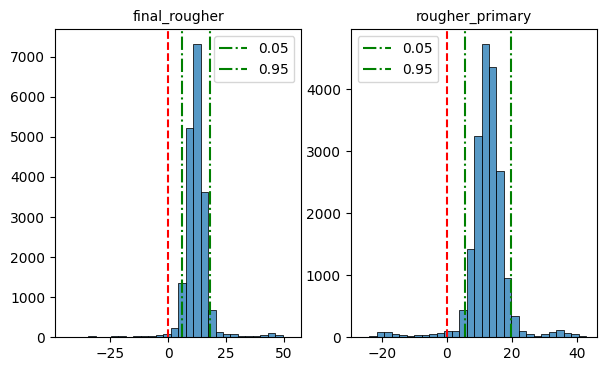

In [114]:
get_sublot(get_concentrane('au'))

Видно, что в целом концентрация золота увеличивается после обработки, хотя есть отклонения, когда концентрация золота уменьшается либо вообще никак не меняется


Нулевая гипотеза: **После обработки концентрация золота уменьшается**

Смотря на график, мы можем утверждать что вероятность получить такой или более значимый результат составляет 95 процентов, при условии, что концентрация золота уменьшается после обработки. То есть мы можем опровергнуть нулевую гипотезу

#### Серебро

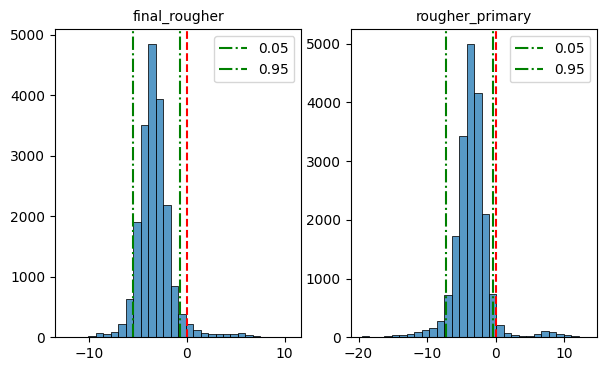

In [115]:
get_sublot(get_concentrane('ag'))

Нулевая гипотеза: **После обработки концентрация серебра увеличивается**

Смотря на график, мы можем утверждать что вероятность получить такой или более значимый результат составляет 95 процентов, при условии, что концентрация серебра увеличивается после обработки. То есть мы можем опровергнуть нулевую гипотезу

#### Свинец

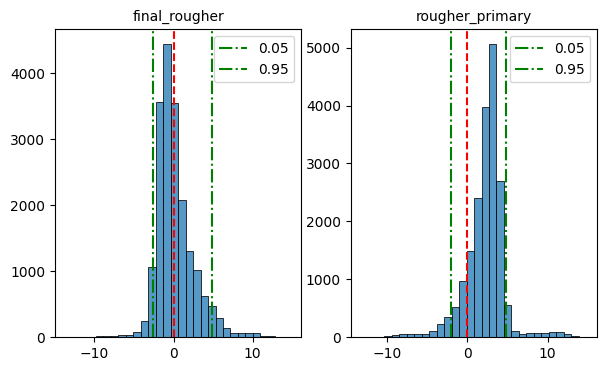

In [116]:
get_sublot(get_concentrane('pb'))

Нулевая гипотеза: **После обработки концентрация свинца увеличивается**

Смотря на график, мы не можем опровергнуть нулевую гипотезу. То есть есть вероятность, что концентрация свинца не меняется и на графике это видно

### Сравните распределения размеров гранул сырья на обучающей и тестовой выборках

In [117]:
'rougher_input_feed_size'

'rougher_input_feed_size'

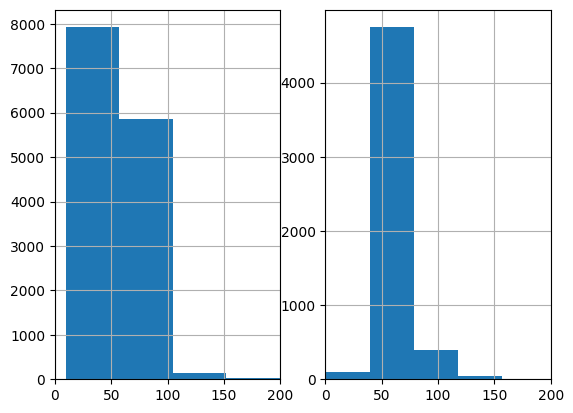

In [118]:
fig, ax = plt.subplots(1,2, sharex=True)

data_gold_recovery_train['rougher_input_feed_size'].dropna().hist(ax = ax[0])
data_gold_recovery_test['rougher_input_feed_size'].dropna().hist(ax = ax[1])

ax[0].set_xlim(0,200)
plt.show()

In [119]:
data_gold_recovery_train['rougher_input_feed_size'].describe()

count    14005.000000
mean        60.110518
std         22.418485
min          9.659576
25%         48.973027
50%         55.373885
75%         66.080172
max        484.967466
Name: rougher_input_feed_size, dtype: float64

In [120]:
data_gold_recovery_test['rougher_input_feed_size'].describe()

count    5289.000000
mean       55.951097
std        19.081758
min         0.046369
25%        43.906347
50%        50.841029
75%        62.431047
max       392.494040
Name: rougher_input_feed_size, dtype: float64

Итого исходя из статистического теста нельзя опровергнуть нулевую гипотезу. Следовательно средние значения разные

Оценим визуально распределения

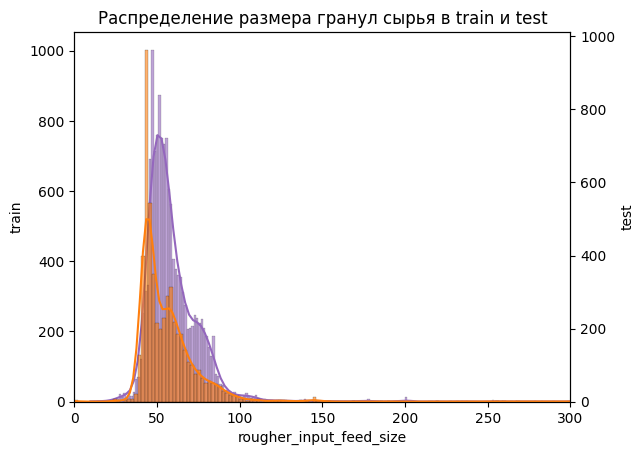

In [121]:
ax1 = sns.histplot(data = data_gold_recovery_train, x = 'rougher_input_feed_size',
                 kde = True, color = 'C4', alpha = 0.6)

ax2=ax1.twinx()

sns.histplot(data = data_gold_recovery_test, x = 'rougher_input_feed_size',
                 kde = True, ax = ax2, color = 'C1', alpha = 0.6)

ax1.set_xlim(0,300)

plt.title("Распределение размера гранул сырья в train и test")
ax1.set_ylabel("train")
ax2.set_ylabel("test")

plt.show()

Итого визуально выборки отличаются

### Исследуйте суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах

In [122]:
data_concentrate = data_gold_recovery_full.copy()

In [123]:
data_concentrate = data_concentrate[[x for x in data_concentrate.columns 
                    if 'concentrate' in x]]

In [124]:
data_concentrate['final_output_concentrate'] = data_concentrate[
                [x for x in data_concentrate.columns 
                if 'final_output_concentrate' in x]].sum(axis = 1).round(2)

data_concentrate['rougher_input_feed'] = data_concentrate[
        [x for x in data_concentrate.columns 
        if 'rougher_input_feed_' in x]].sum(axis = 1).round(2)

data_concentrate['rougher_output_concentrate'] = data_concentrate[
        [x for x in data_concentrate.columns 
        if 'rougher_output_concentrate' in x]].sum(axis = 1).round(2)

In [125]:
data_concentrate = data_concentrate[['final_output_concentrate',
                  'rougher_input_feed',
                  'rougher_output_concentrate']].dropna()

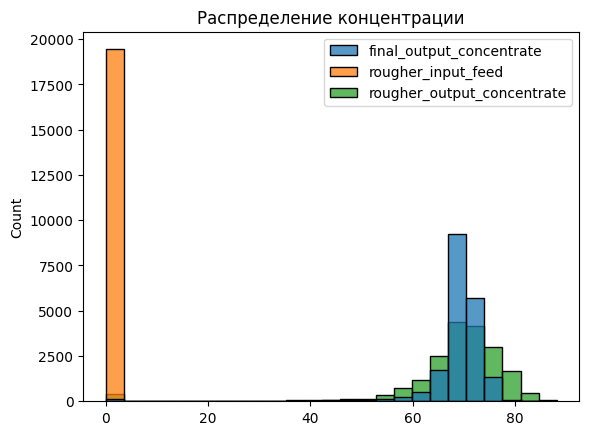

In [126]:
sns.histplot(data_concentrate)
plt.title('Распределение концентрации')
plt.show()

Значений с концентрацией равной нулу быть не может. На тесте концентрация не подсчитана, удалим её на трейне

In [129]:
data_gold_recovery_train['final_output_concentrate'] = data_gold_recovery_train[
                [x for x in data_gold_recovery_train.columns 
                if 'final_output_concentrate' in x]].sum(axis = 1).round(2)

data_gold_recovery_train['rougher_input_feed'] = data_gold_recovery_train[
        [x for x in data_gold_recovery_train.columns 
        if 'rougher_input_feed' in x]].sum(axis = 1).round(2)

data_gold_recovery_train['rougher_output_concentrate'] = data_gold_recovery_train[
        [x for x in data_gold_recovery_train.columns 
        if 'rougher_output_concentrate' in x]].sum(axis = 1).round(2)

In [130]:
index = data_gold_recovery_train.query('final_output_concentrate != 0 and '
                               'rougher_input_feed != 0 and '
                               'rougher_output_concentrate != 0').index

In [131]:
features_train = features_train.loc[index]
target_train = target_train.loc[index]

Итого мы выделили строки, где концентрация не равна нулю ни на одном из этапов, нашли индексы и подставили их в тестовую переменную

## Построение модели

### Для начала обучим модель с функцией mape

Пишем собственную функцию с учетом того, что сначала идёт флотация

In [132]:
def calculate_smape(target, predictions):
    numerator = np.abs(target - predictions)
    denominator = (np.abs(target) + np.abs(predictions)) / 2 

    return 1 / len(target) * np.sum(numerator / denominator) * 100 


def smape(target, predictions):
    smape25 = 0.25 * calculate_smape(target[:,0], predictions[:,0])
    smape75 = 0.75 * calculate_smape(target[:,1], predictions[:,1])
    
    return smape25 + smape75


target_metric = make_scorer(calculate_smape, greater_is_better=False)

In [133]:
regressor = RandomForestRegressor(random_state = RANDOM_STATE)

parameters = {
    'n_estimators': [11],
    'max_depth': [71],
    'max_features': [51]
}

target_metric_1 = make_scorer(mean_squared_error, greater_is_better=False)

scoring = {"smape1": target_metric,"smape2": target_metric}

In [134]:
def refit_strategy(cv_):
    return (0.25 * cv_['mean_test_smape1'] + 
            0.75 * cv_['mean_test_smape2']).argmax()

In [135]:
gs = RandomizedSearchCV(regressor,
                  parameters,
                  scoring=scoring,
                  refit=refit_strategy,
                  cv = 5,verbose = 2,
                  n_iter = 1,
                  random_state =RANDOM_STATE)

In [136]:
gs.fit(features_train,target_train.values)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END .....max_depth=71, max_features=51, n_estimators=11; total time=   5.0s
[CV] END .....max_depth=71, max_features=51, n_estimators=11; total time=   4.8s
[CV] END .....max_depth=71, max_features=51, n_estimators=11; total time=   4.6s
[CV] END .....max_depth=71, max_features=51, n_estimators=11; total time=   4.6s
[CV] END .....max_depth=71, max_features=51, n_estimators=11; total time=   4.8s


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=777),
                   n_iter=1,
                   param_distributions={'max_depth': [71], 'max_features': [51],
                                        'n_estimators': [11]},
                   random_state=777,
                   refit=<function refit_strategy at 0x00000154ACD4B280>,
                   scoring={'smape1': make_scorer(calculate_smape, greater_is_better=False),
                            'smape2': make_scorer(calculate_smape, greater_is_better=False)},
                   verbose=2)

In [137]:
gs.best_params_

{'n_estimators': 11, 'max_features': 51, 'max_depth': 71}

In [138]:
smape(target_test.values, gs.predict(features_test))

10.973653348026613

Модель с регуляризацией

In [139]:
ls = ElasticNet(random_state = RANDOM_STATE)
parameters =  {
    'l1_ratio' : np.linspace(0.1,1,10),
    'alpha': np.linspace(0.1,1,10),
}

In [140]:
gs_ls = RandomizedSearchCV(ls,
                  parameters,
                  scoring=scoring,
                  refit=refit_strategy,
                  cv = 5,verbose = 1,
                  n_iter = 5,
                  random_state =RANDOM_STATE)

In [141]:
gs_ls.fit(features_train,target_train.values)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


RandomizedSearchCV(cv=5, estimator=ElasticNet(random_state=777), n_iter=5,
                   param_distributions={'alpha': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                                        'l1_ratio': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])},
                   random_state=777,
                   refit=<function refit_strategy at 0x00000154ACD4B280>,
                   scoring={'smape1': make_scorer(calculate_smape, greater_is_better=False),
                            'smape2': make_scorer(calculate_smape, greater_is_better=False)},
                   verbose=1)

In [142]:
smape(target_test.values, gs_ls.predict(features_test))

9.20643522834468

In [143]:
gs_ls.best_params_

{'l1_ratio': 0.2, 'alpha': 0.1}

Бустинг

In [144]:
cat = CatBoostRegressor(loss_function = 'MultiRMSE', 
                        verbose = 1,
                       iterations = 30,
                       depth = 15,
                       l2_leaf_reg = 0.1)

parameters = {

}

In [145]:
gs_cat = RandomizedSearchCV(cat,
                  parameters,
                  scoring=scoring,
                  refit = refit_strategy,
                  cv = 5,verbose = 1,
                  n_iter = 1,
                  random_state =RANDOM_STATE)

In [146]:
# gs_cat.fit(features_train,target_train.values)

In [147]:
# smape(target_test.values, gs_cat.predict(features_test))

### Проверка модели на адекватность

In [148]:
dt = DummyRegressor(strategy = 'median')

In [149]:
dt.fit(features_train, target_train)
predict = dt.predict(features_test)

In [150]:
smape(target_test.values, predict)

9.43899456364264

# ИТОГО

 1. Модель регрессии с регуляризацией показала себя лучше всего
 2. Рандомный лес показал себя хуже, чем остальные модели. Для данных задач данный метод не подходит. Даже Dummy модель показала себя лучше
 3. Протестирован CatBoost. В целом модель лучше рандомного леса, но скорее всего гиперпараметры можно было подобрать получше
 4. Во всех моделях обучение шло за счет кросс-валидации, так же был использован RobustScaler, так как были возможны выбросы
 5. Для заполнения пропусков был использован IterativeImputer со стратегией K ближайших соседей
 6. Была написана собственная функция sMAPE и по ней обучена модель
 7. Концентрация золота и серебра после очистки увеличивается
 8. Суммарная концентрация вещества снижается после обработки